# Formula 1 Lap Time Prediction

## Introduction
This notebook presents a predictive regression project to estimate a Formula 1 driver's lap time during a race.
The goal is to build a model capable of predicting lap time based on key race variables, such as tire age and lap number.
This type of model is fundamental for strategic analysis and real-time decision-making.


## 1. Environment and Data Preparation

In [27]:
import fastf1 as ff1
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from fastf1 import plotting
import matplotlib.pyplot as plt

plotting.setup_mpl()
ff1.Cache.enable_cache('../data')  # enable cache folder

# Load race session data
session = ff1.get_session(2024, 'Hungarian Grand Prix', 'R')
session.load(telemetry=False, weather=True)

# Get all clean laps (excluding pit-in/out laps)
laps = session.laps.pick_accurate()
# laps = laps.pick_driver('LEC')

# Weather data (resampled every minute)
weather = session.weather_data

# Weather data
weather = session.weather_data.rename(columns={'Time': 'WeatherTime'})

# Merge with nearest timestamp (backward means we take the latest weather before the lap started)
laps = pd.merge_asof(
    laps.sort_values("LapStartTime"),
    weather[['WeatherTime', 'AirTemp', 'TrackTemp']].sort_values("WeatherTime"),
    left_on="LapStartTime",
    right_on="WeatherTime",
    direction="backward"
)

core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']


## 2. Feature Engineering

In [28]:
# Target variable (y): Lap time in seconds
laps['LapTime (s)'] = laps['LapTime'].dt.total_seconds()

# Tire age per stint
laps['TireAge'] = laps['LapNumber'] - laps.groupby('Stint')['LapNumber'].transform('first') + 1

# Encode categorical variables: Compound and Driver
laps['Compound'] = laps['Compound'].astype('category').cat.codes
laps['Driver'] = laps['Driver'].astype('category').cat.codes

# Select features and target
features = ['LapNumber', 'TireAge', 'Compound', 'Driver', 'AirTemp', 'TrackTemp']
target = 'LapTime (s)'

X = laps[features]
y = laps.loc[X.index, target]

print(f"Number of laps for training: {len(X)}")
print("Data preview:")
print(X.head())

Number of laps for training: 1254
Data preview:
   LapNumber  TireAge  Compound  Driver  AirTemp  TrackTemp
0        2.0      1.0         1      11     28.9       45.5
1        2.0      1.0         1      18     28.9       45.5
2        2.0      1.0         1       8     28.9       45.5
3        2.0      1.0         1       4     28.9       45.5
4        2.0      1.0         1       6     28.9       45.5


## 3. Model Building and Training

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Training the model...")
model.fit(X_train, y_train)
print("Training complete.")

Training the model...
Training complete.


## 4. Model Evaluation and Results

In [30]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

Mean Squared Error (MSE): 0.6287
R-squared (R2) Score: 0.6307


## 5. Visualization and Interpretation

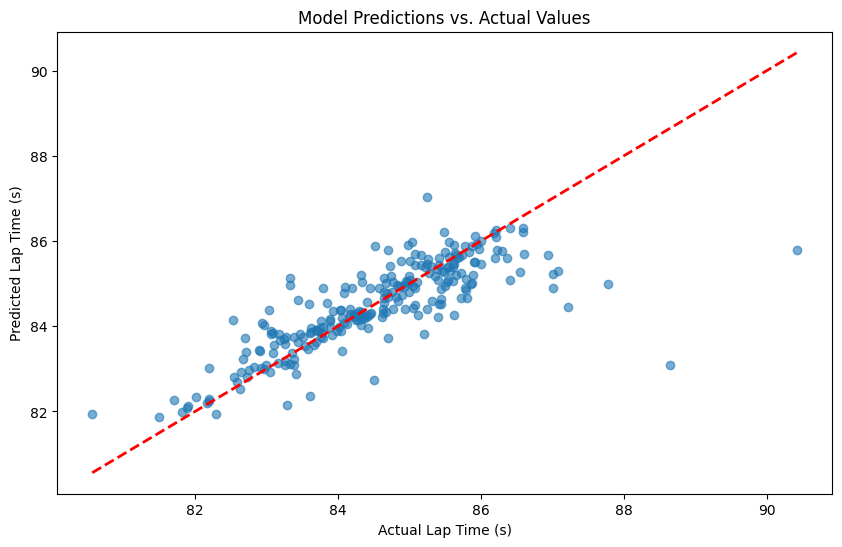

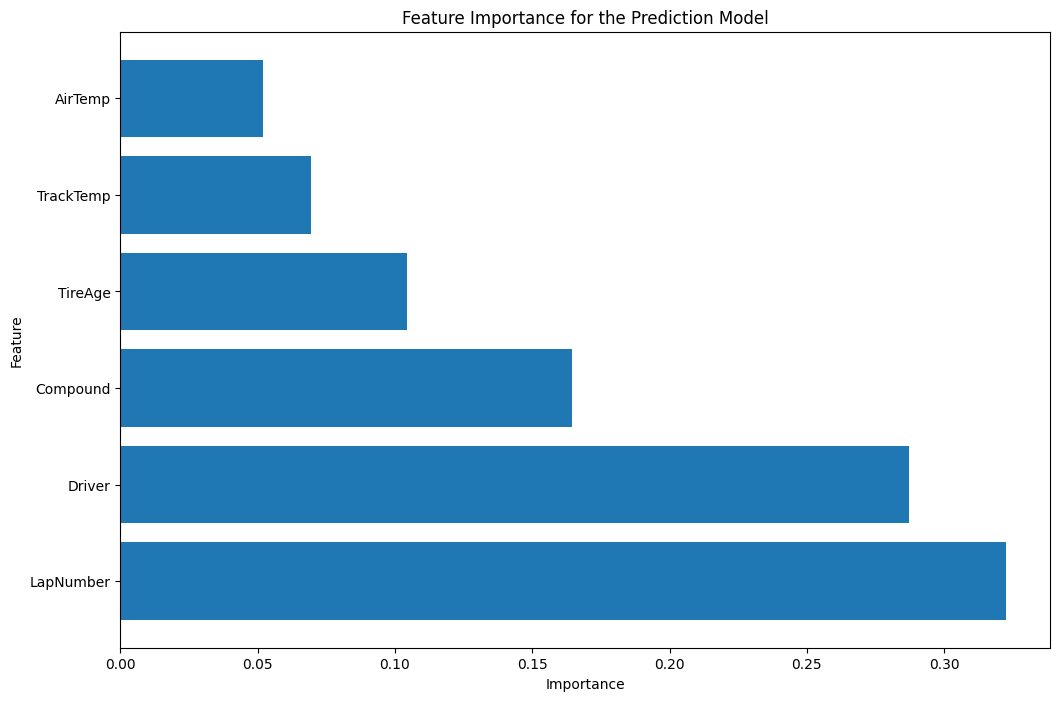

In [31]:
# Predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Model Predictions vs. Actual Values')
plt.show()

# Feature importance
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for the Prediction Model')
plt.show()

## Conclusion

The Random Forest Regressor model achieved an R² score of approximately 0.63 and a Mean Squared Error (MSE) of about 0.63.

These results indicate that the model is capable of explaining roughly 63% of the variance in lap times. While not perfect, this is a significant performance given the simplicity of the variables used.

The most influential factors on the predictions were:
- Lap Number
- Driver
- Tire compound
- Tire Age

This confirms well-known trends in F1:
- Lap times increase as tires age.
- Tire degradation and strategy are major determinants of performance.
- Weather and track temperature strongly influence lap times.

**Limitations:** The model does not yet account for other key variables such as fuel load, race events (safety cars, yellow flags), or the relative pace between drivers. These factors explain why the prediction is not perfect.

**Next Steps:**
- Integrate telemetry data (speeds, braking, sectors).
- Model fuel consumption and the associated performance loss.
- Compare driving styles between teammates.
- Test other algorithms (XGBoost, neural networks) to gain further precision.